In [1]:
! pip install tensorflow
! pip install numpy
! pip install matplotlib
! pip install pandas
! pip install scikit-learn
! pip install seaborn
! pip install keras
! pip install nltk

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/375.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/375.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/375.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/375.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/375.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/375.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/375.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/375.7 MB ? eta -:--:--
   ---------------------------------------- 0.3/375.7 MB ? eta -:--:--
   ---------------------------------------- 0.3/375.7 MB ? eta -:--:--
   ---------------------------------------- 0.3/375.7 MB ? eta -:--:--
   ---------------------------------------- 0.3/375.7 MB ? eta -:--:--
   ---------------------------------------- 0.3/375.7 MB ? eta -:--:--
   -

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.11.2 requires numpy<1.28.0,>=1.21.6, but you have numpy 2.1.3 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/15.8 MB ? eta -:--:--
    --------------------------------------- 0.3/15.8 MB ? eta -:--:--
   - -------------------------------------- 0.8/15.8 MB 2.4 MB/s eta 0:00:07
   --- ------------------------------------ 1.3/15.8 MB 2.3 MB/s eta 0:00:07
   --- ------------------------------------ 1.6/15.8 MB 2.3 MB/s eta 0:00:07
   ---- ----------------------------------- 1.8/15.8 MB 2.0 MB/s eta 0:00:08
   ----- ---------------------------------- 2.1/15.8 MB 1.9 MB/s eta 0:00:08
   ----- ---------------------------------- 2.4/15.8 MB 1.6 MB/s eta 0:00:09
   ----- ---------------------------------- 2.4/15.8 MB 1.6 MB/s eta 0:00:09
   ------ -------------------

## **Import Library**

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string

from sklearn.model_selection import train_test_split

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import os
import requests
from bs4 import BeautifulSoup
import nltk

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [33]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

### **Load data**

In [19]:
imdb_df = pd.read_csv("../Data/IMDB Dataset.csv")
rotten_df = pd.read_csv("../Data/rotten_tomatoes_critic_reviews.csv")
imdb_df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [20]:
imdb_df.shape, rotten_df.shape

((50000, 2), (1130017, 8))

In [21]:
imdb_df.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [22]:
rotten_df.head(5)

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...


In [23]:
rotten_df.review_type.value_counts()

Fresh     720210
Rotten    409807
Name: review_type, dtype: int64

In [24]:
view_df = rotten_df[["review_type", "review_content"]]
view_df.head()

,review_type,review_content
0,Fresh,A fantasy adventure that fuses Greek mythology...
1,Fresh,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,Fresh,With a top-notch cast and dazzling special eff...
3,Fresh,Whether audiences will get behind The Lightnin...
4,Rotten,What's really lacking in The Lightning Thief i...


Data is imbalanced, so we need to get more rotten review, or negative review.

In [5]:
def initialize_chrome_driver():
   """
   Initialize Chrome WebDriver with specific configurations
   
   Args:
       user_name (str): Windows username for Chrome profile path
       
   Returns:
       webdriver.Chrome: Configured Chrome WebDriver instance
   """
   # Configure Chrome options
   chrome_options = Options()
   chrome_options.add_argument("--no-sandbox")
   chrome_options.add_argument("--start-maximized")
   chrome_options.add_argument("--disable-blink-features=AutomationControlled")
   
   # Configure download preferences
   chrome_options.add_experimental_option("prefs", {
       "download.default_directory": os.getcwd() + '\Data',
       "download.prompt_for_download": False,
       "profile.default_content_setting_values.automatic_downloads": 1,
       "profile.default_content_setting_values.popups": 0,
   })
   
   # Initialize and return WebDriver
   return webdriver.Chrome(
       # Your path that contains chromedriver
       service=Service("D:/NLP/chromedriver-win64/chromedriver-win64/chromedriver.exe"), 
       options=chrome_options
   )

In [6]:
type_movies = ["movies_coming_soon", "movies_at_home", "movies_in_theaters", "tv_series_browse"]
list_films = {}

def get_list_film(base_url: str):
    browser = initialize_chrome_driver()
    browser.get(base_url)
    
    time.sleep(5) 
    
    soup = BeautifulSoup(browser.page_source, "html.parser")
    
    list_film = {}

    poster_cards = soup.find_all("a", class_="c-finderProductCard_container")
    
    for poster_card in poster_cards:       
        if poster_card:
            href_value = "https://www.metacritic.com" + poster_card["href"] 
            poster_card = poster_card.find("h3")
            if poster_card:
                spans = poster_card.find_all("span")
                if len(spans) > 1:
                    title = spans[1].text
                else:
                    title = spans[0].text
                list_film[title] = href_value


    browser.quit()
    
    return list_film

base_url = "https://www.metacritic.com/browse/movie/?releaseYearMin=1910&releaseYearMax=2025&page="

for i in range (600, 694):
    list_films.update(get_list_film(base_url + str(i)))

# list_films.update(get_list_film(base_url + str(600)))

In [7]:
print(len(list_films))

2227


In [8]:
list_critics_reviews = {}

for title, href in list_films.items():
    list_critics_reviews[title] = href+"critic-reviews/"

In [9]:
list_critics_reviews["Marilyn Hotchkiss' Ballroom Dancing & Charm School"]

'https://www.metacritic.com/movie/marilyn-hotchkiss-ballroom-dancing-charm-school/critic-reviews/'

In [13]:
final_reviews = []
def get_reviews(base_url: str):
    browser = initialize_chrome_driver()
    browser.get(base_url)
    
    time.sleep(5) 
    
    soup = BeautifulSoup(browser.page_source, "html.parser")
    
    reviews = []
    
    review_cards = soup.find_all("div", class_="c-siteReview_main")
    
    for review_card in review_cards:
        if review_card:
            score_card = review_card.find("div", class_="c-siteReviewHeader_reviewScore")
            if score_card:
                score_card = score_card.find("span").text
                if int(score_card) >= 50:
                    continue
            comment_card = review_card.find("div", class_="c-siteReview_quote")
            if comment_card:
                comment_card = comment_card.find("span").text
            review = {"review": comment_card, "sentiment": "negative"}
            reviews.append(review)
    
    browser.quit()
    
    return reviews

for title, href in list_critics_reviews.items():
    final_reviews += get_reviews(href)

In [14]:
len(final_reviews)

22109

In [16]:
folder_path = "../Data"
file_name = "metacritic_reviews.csv"
full_path = os.path.join(folder_path, file_name)

os.makedirs(folder_path, exist_ok=True)

metacritic_df = pd.DataFrame(final_reviews)

metacritic_df.to_csv(full_path, index=False, encoding="utf-8")

print(f"Data successfully written to {full_path}")

Data successfully written to ../Data\metacritic_reviews.csv


## **Text Preprocessing**

### **Convert String values to Numeric**

In [25]:
imdb_df["label"] = imdb_df["sentiment"].apply(lambda x: 1 if x == "positive" else 0)
imdb_df.head()

,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [26]:
metacritic_df["label"] = metacritic_df["sentiment"].apply(lambda x: 1 if x == "positive" else 0)
metacritic_df.head()

,review,sentiment,label
0,"The ""What The Bleep Do We Know?"" crowd may wel...",negative,0
1,You'd have to be either an avid New Ager or wi...,negative,0
2,"For all its manifest corniness, this is an ach...",negative,0
3,"The cast is quite good. But Peaceful Warrior, ...",negative,0
4,The intriguing thing about The Peaceful Warrio...,negative,0


In [27]:
rotten_df["label"] = rotten_df["review_type"].apply(lambda x: 1 if x == "Fresh" else 0)
rotten_df.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,label
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...,1
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff...",1
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...,1
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...,1
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...,0


## **Data Cleaning**

In [28]:
def preprocessing(text):
    text = str(text)
    text = re.sub(r'^RT[\s]+', '', text)
    text = re.sub(r'<br />', '', text)
    text = text.replace("\'", "")
    
    tokens = text.split()
    stopwords_english = stopwords.words("english")
    stemmer = PorterStemmer()
    
    cleaned_words = []

    for x in tokens:
        if (x not in stopwords_english and string.punctuation):
            stem_word = stemmer.stem(x)
            cleaned_words.append(stem_word)
    return ' '.join(cleaned_words)

In [34]:
imdb_df["cleaned_text"] = imdb_df["review"].apply(preprocessing)
imdb_df.head()

,review,sentiment,label,cleaned_text
0,One of the other reviewers has mentioned that ...,positive,1,one review mention watch 1 oz episod youll hoo...
1,A wonderful little production. <br /><br />The...,positive,1,a wonder littl production. the film techniqu u...
2,I thought this was a wonderful way to spend ti...,positive,1,i thought wonder way spend time hot summer wee...
3,Basically there's a family where a little boy ...,negative,0,basic there famili littl boy (jake) think ther...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,"petter mattei ""love time money"" visual stun fi..."


In [35]:
rotten_df["cleaned_text"] = rotten_df["review_content"].apply(preprocessing)
rotten_df.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,label,cleaned_text
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...,1,a fantasi adventur fuse greek mytholog contemp...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff...",1,"uma thurman medusa, gorgon coiffur writh snake..."
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...,1,"with top-notch cast dazzl special effects, tid..."
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...,1,whether audienc get behind the lightn thief ha...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...,0,what realli lack the lightn thief genuin sens ...


In [36]:
metacritic_df["cleaned_text"] = metacritic_df["review"].apply(preprocessing)
metacritic_df.head()

,review,sentiment,label,cleaned_text
0,"The ""What The Bleep Do We Know?"" crowd may wel...",negative,0,"the ""what the bleep do we know?"" crowd may wel..."
1,You'd have to be either an avid New Ager or wi...,negative,0,youd either avid new ager will see nick nolt a...
2,"For all its manifest corniness, this is an ach...",negative,0,"for manifest corniness, achingli sincer suprem..."
3,"The cast is quite good. But Peaceful Warrior, ...",negative,0,"the cast quit good. but peac warrior, basic ""t..."
4,The intriguing thing about The Peaceful Warrio...,negative,0,the intrigu thing the peac warrior noth els mo...


## **Combine 3 dataset**

In [ ]:
os.makedirs("../Data/CleanData", exist_ok=True)
folder_path = "../Data/CleanData"
file_name = "final_reviews.csv"
full_path = os.path.join(folder_path, file_name)

combined_df = pd.concat([imdb_df.iloc[:45000][['cleaned_text', 'label']], 
                         rotten_df.iloc[:110000][['cleaned_text', 'label']], 
                         metacritic_df[['cleaned_text', 'label']]],
                         ignore_index=True)


combined_df.to_csv(full_path, index=False, encoding="utf-8")

print(combined_df.head())
print(combined_df.shape)

                                        cleaned_text  label
0  one review mention watch 1 oz episod youll hoo...      1
1  a wonder littl production. the film techniqu u...      1
2  i thought wonder way spend time hot summer wee...      1
3  basic there famili littl boy (jake) think ther...      0
4  petter mattei "love time money" visual stun fi...      1
(177109, 2)


In [68]:
combined_df.label.value_counts()

1    89786
0    87323
Name: label, dtype: int64

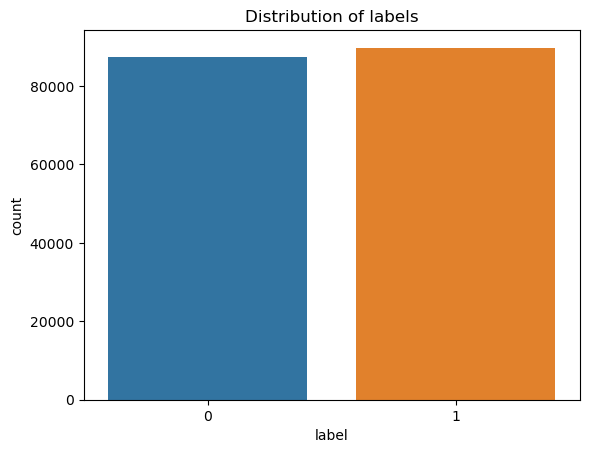

In [69]:
sns.countplot(data=combined_df, x="label")
plt.title("Distribution of labels")
plt.show()